# Customer Churn Prediction (Notebook)

**Goal:** Train a baseline churn model and score new rows using a clean scikit-learn pipeline.

**Columns (EN):** `customer_id, gender, senior_citizen, tenure_months, contract_type, internet_service, payment_method, dependents, partner, tech_support, monthly_charges, total_charges, city, region, churn`.

> If `data/churn.csv` is missing, the next cell will **generate a synthetic dataset** automatically.

In [ ]:
import sys, subprocess
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs])

pip_install(["pandas","numpy","scikit-learn","matplotlib","joblib"])

In [1]:
import os, csv, random
import pandas as pd

os.makedirs("data", exist_ok=True)

data_path = "data/churn.csv"
if not os.path.exists(data_path):
    random.seed(7)
    header = [
        "customer_id","gender","senior_citizen","tenure_months","contract_type",
        "internet_service","payment_method","dependents","partner","tech_support",
        "monthly_charges","total_charges","city","region","churn"
    ]

    def synth_row(i):
        gender = random.choice(["Male","Female"])
        senior = random.choices([0,1],[0.84,0.16])[0]
        tenure = max(1, int(random.gauss(22, 12)))
        contract = random.choices(["Month-to-month","One year","Two year"],[0.62,0.25,0.13])[0]
        internet = random.choices(["Fiber optic","DSL","None"],[0.52,0.38,0.10])[0]
        payment = random.choices(["Electronic check","Credit card","Bank transfer","Mailed check"],[0.48,0.18,0.20,0.14])[0]
        dependents = random.choices(["Yes","No"],[0.3,0.7])[0]
        partner = random.choices(["Yes","No"],[0.45,0.55])[0]
        tech_support = random.choices(["Yes","No"],[0.4,0.6])[0]
        base_price = 20
        internet_add = {"None":0, "DSL":25, "Fiber optic":45}[internet]
        support_add = 6 if tech_support=="Yes" else 0
        monthly = round(base_price + internet_add + support_add + random.uniform(-3, 8), 2)
        total = round(monthly * tenure + random.uniform(-15, 30), 2)
        p = 0.18
        if contract == "Month-to-month": p += 0.22
        if internet == "Fiber optic": p += 0.08
        if tech_support == "No": p += 0.07
        if tenure < 6: p += 0.18
        if monthly > 80: p += 0.06
        if senior == 1: p += 0.03
        churn = "Yes" if random.random() < max(0.03, min(0.92, p)) else "No"
        city = random.choice(["Miami","Austin","Denver","Seattle","Orlando","Phoenix","Boston","Chicago"])
        region = random.choice(["US-East","US-South","US-West","US-North"])
        return [f"C{i:05d}", gender, senior, tenure, contract, internet, payment, dependents, partner, tech_support, monthly, total, city, region, churn]

    with open(data_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)
        for i in range(1, 1201):
            w.writerow(synth_row(i))

df = pd.read_csv(data_path)
df.head()

,customer_id,gender,senior_citizen,tenure_months,contract_type,internet_service,payment_method,dependents,partner,tech_support,monthly_charges,total_charges,city,region,churn
0,C00001,Female,1,19,One year,Fiber optic,Credit card,No,Yes,Yes,72.60,1375.23,Miami,US-East,No
1,C00002,Male,0,24,Month-to-month,Fiber optic,Credit card,Yes,Yes,No,63.46,1526.90,Orlando,US-South,Yes
2,C00003,Male,0,14,Month-to-month,Fiber optic,Electronic check,Yes,No,No,65.46,927.79,Orlando,US-South,Yes
3,C00004,Male,0,13,Month-to-month,DSL,Credit card,No,No,Yes,58.78,754.45,Phoenix,US-South,No
4,C00005,Female,0,26,Month-to-month,DSL,Bank transfer,No,Yes,No,50.77,1308.11,Orlando,US-North,Yes


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

y = (df["churn"].str.strip().str.title() == "Yes").astype(int)
X = df.drop(columns=["churn","customer_id"])  # drop ID and target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","bool"]).columns.tolist()

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

clf = LogisticRegression(max_iter=2000, class_weight="balanced")
pipe = Pipeline([("pre", pre), ("clf", clf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
print()
print(classification_report(y_test, y_pred, digits=3))

AUC: 0.6581

              precision    recall  f1-score   support

           0      0.686     0.522     0.593       134
           1      0.536     0.698     0.607       106

    accuracy                          0.600       240
   macro avg      0.611     0.610     0.600       240
weighted avg      0.620     0.600     0.599       240



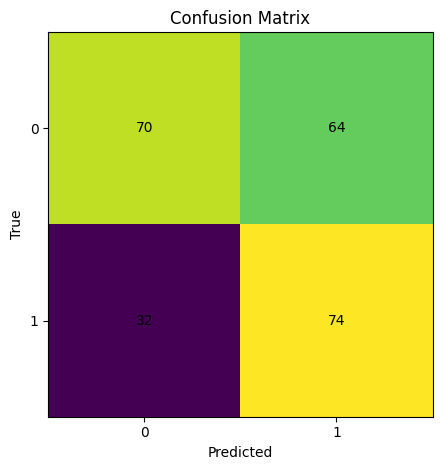

In [3]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_title("Confusion Matrix")
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
fig.tight_layout()
plt.show()

In [4]:
import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(pipe, "models/model.pkl")
print("Saved models/model.pkl")

Saved models/model.pkl


In [5]:
import pandas as pd, os, joblib
os.makedirs("reports", exist_ok=True)

sample_path = "data/sample_to_score.csv"
if not os.path.exists(sample_path):
    sample = df.drop(columns=["churn"]).head(5)
    sample.to_csv(sample_path, index=False)

to_score = pd.read_csv(sample_path)
model = joblib.load("models/model.pkl")
X_new = to_score.drop(columns=[c for c in ["churn","churn_flag","customer_id"] if c in to_score.columns], errors="ignore")
proba = model.predict_proba(X_new)[:,1]
preds = (proba >= 0.5).astype(int)

scored = to_score.copy()
scored["churn_score"] = proba.round(4)
scored["churn_pred"] = preds

out_path = "reports/scored.csv"
scored.to_csv(out_path, index=False)
scored.head(10)

,customer_id,gender,senior_citizen,tenure_months,contract_type,internet_service,payment_method,dependents,partner,tech_support,monthly_charges,total_charges,city,region,churn_score,churn_pred
0,C00001,Female,1,19,One year,Fiber optic,Credit card,No,Yes,Yes,72.60,1375.23,Miami,US-East,0.2419,0
1,C00002,Male,0,24,Month-to-month,Fiber optic,Credit card,Yes,Yes,No,63.46,1526.90,Orlando,US-South,0.5803,1
2,C00003,Male,0,14,Month-to-month,Fiber optic,Electronic check,Yes,No,No,65.46,927.79,Orlando,US-South,0.6458,1
3,C00004,Male,0,13,Month-to-month,DSL,Credit card,No,No,Yes,58.78,754.45,Phoenix,US-South,0.4778,0
4,C00005,Female,0,26,Month-to-month,DSL,Bank transfer,No,Yes,No,50.77,1308.11,Orlando,US-North,0.5959,1


**Done!** Model saved to `models/model.pkl`. Scored CSV saved to `reports/scored.csv`.